<a href="https://colab.research.google.com/github/NSR9/EVA8/blob/main/Session-4/S4_step_3_adding_fancy_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target: 
1. Acheive 99.4 % test accuracy in less than 15 epochs with less than 10K parameters and maintain the same in the last few epochs.

## Changes Made
1. Adding BatchNorm after each layer in the network
2. Adding Dropout after each layer in the network
3. Placing the maxpooling at receptive field of 5x5 in the network
4. Adding GAP in the network
5. Adding a Fully connected layer after GAP in the network
6. Implementing LR Scheduler
7. Adding Image augmentation strategies like randomrotation, horizontalflip

## What to expect
1. Improvement in the train and test accuracies
2. less gap between the train and test accuracies

## Results:
1. Best Training Accuracy : 99% at 14th Epoch
2. Best Test Accuracy : 99.43% at 14th Epoch
3. Params: 8,878

## Analysis:
1. The target is acheived in 15 epochs. 
2. The accuracy of 99.4% maintained for the last 5 epochs. 
3. Model is underfitting with low train accuracy and high test accuracy. 
4. The difference between train and test accuracies is less.

## CALLING THE GODS!

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Model Definition

In [ ]:
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import ReLU
d = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block 
        self.inputblock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1),     # 28x28 >> 28x28 Rf = 3
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(d)
        )

        # Conv block 1 
        self.convblock1 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=1),                                          # 28x28 >> 28x28 Rf = 5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(d)  
        )

        self.transitionblock1 = nn.Sequential(
            nn.MaxPool2d(2,2),   
            nn.Conv2d(16, 8, 1, padding=0),                                          # 7x7 >> 7x7. Rf = 16
            nn.ReLU()                                                    # 28x28 >> 14x14 Rf = 6
        )

        self.convblock2 = nn.Sequential(        
            nn.Conv2d(8, 10, 3, padding=1),                                          # 14x14 >> 14x14 Rf = 10
            nn.ReLU(), 
            nn.BatchNorm2d(10),   
            nn.Dropout(d),  
            nn.Conv2d(10, 16, 3, padding=1),                                         # 14x14 >> 14x14 Rf = 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(d)

        )

        self.transitionblock2 = nn.Sequential(
            nn.MaxPool2d(2,2),                                                       # 14x14 >> 7x7 Rf = 16
            nn.Conv2d(16, 8, 1, padding=0),                                          # 7x7 >> 7x7. Rf = 16
            nn.ReLU()

        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(8, 10, 3, padding=0),                                          # 7x7 >> 5x5 Rf = 24
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(d),                     
            nn.Conv2d(10, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(d), 
            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(d),                                          # 5x5 >> 3x3 Rf = 32 
            nn.AvgPool2d(3),
            nn.Conv2d(16, 10, 1, padding=0)                                          # 3x3 >> 1x1 Rf = 40
            
        )
        


        

    def forward(self, x):
        x = self.inputblock(x)
        x = self.convblock1(x)
        x = self.transitionblock1(x)
        x = self.convblock2(x)
        x = self.transitionblock2(x)
        x = self.convblock3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

## Model Summary 

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 10, 14, 14]             730
    

<ipython-input-129-3bd8ac46fe15>:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## Initializing Data Transformation objects for Train and Test data

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Initializing Train and Test dataloders for MNIST Dataset

In [ ]:

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Inspecting the Train data

torch.Size([128, 1, 28, 28])
torch.Size([128])


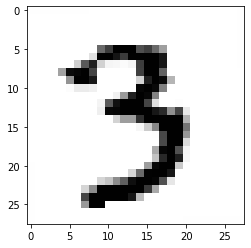

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

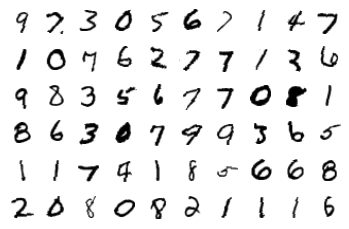

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Train and Test Definitions

In [ ]:
from tqdm import tqdm

train_losses = []
train_accs = []
test_losses = []
test_accs= []

def train(model, device, train_loader, optimizer, epoch):
    correct_preds = 0
    processed = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Porting the data and targets in to the GPU
        data, target = data.to(device), target.to(device)

        # setting all the gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Loss calculation 
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Back propogation
        loss.backward()

        # Updating the weights with calculated gradients
        optimizer.step()

        # Calculating the correct number of predictions
        preds = output.argmax(dim=1, keepdim=True)
        correct_preds += preds.eq(target.view_as(preds)).sum().item()
        processed += len(data)
        
        # Logging the results using Pbar
        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct_preds/processed:0.2f}')

        # Appending the training accuracies to the train_accs[]
        train_accs.append(100*correct_preds/processed)
        


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Porting the data and targets in to the GPU
            data, target = data.to(device), target.to(device)

            # Predict 
            output = model(data)

            # Test loss calculation
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accs.append(100. * correct / len(test_loader.dataset))

## Training and Test loops

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 15
for epoch in range(0, num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-129-3bd8ac46fe15>:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Epoch=0 Loss=0.15047958493232727 Batch_id=468 Accuracy=88.88: 100%|██████████| 469/469 [00:06<00:00, 70.12it/s]



Test set: Average loss: 0.0843, Accuracy: 9769/10000 (97.69%)



Epoch=1 Loss=0.04363046959042549 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:06<00:00, 70.21it/s]



Test set: Average loss: 0.0436, Accuracy: 9859/10000 (98.59%)



Epoch=2 Loss=0.020706115290522575 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:06<00:00, 69.99it/s]



Test set: Average loss: 0.0427, Accuracy: 9869/10000 (98.69%)



Epoch=3 Loss=0.02163967303931713 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:06<00:00, 69.20it/s]



Test set: Average loss: 0.0289, Accuracy: 9913/10000 (99.13%)



Epoch=4 Loss=0.007190991193056107 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:06<00:00, 71.36it/s]



Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)



Epoch=5 Loss=0.06494271010160446 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:06<00:00, 69.51it/s]



Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)



Epoch=6 Loss=0.010541562922298908 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:06<00:00, 69.54it/s]



Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)



Epoch=7 Loss=0.09586929529905319 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:06<00:00, 71.72it/s]



Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)



Epoch=8 Loss=0.02109113335609436 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:06<00:00, 71.54it/s]



Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)



Epoch=9 Loss=0.05349855124950409 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:06<00:00, 70.63it/s]



Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)



Epoch=10 Loss=0.028526214882731438 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:06<00:00, 68.89it/s]



Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)



Epoch=11 Loss=0.02253641188144684 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:06<00:00, 70.47it/s]



Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)



Epoch=12 Loss=0.04347610101103783 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:06<00:00, 70.01it/s]



Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)



Epoch=13 Loss=0.07090843468904495 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:06<00:00, 70.18it/s]



Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)



Epoch=14 Loss=0.05884191393852234 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:06<00:00, 69.14it/s]



Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)



In [ ]:
import numpy 
train_losses = [i.cpu().detach().numpy() for i in train_losses]

In [ ]:

test_losses = [i for i in test_losses]
train_accs = [i for i in train_accs]
test_accs = [i for i in test_accs]


## Training and testing Curves

Text(0.5, 1.0, 'Test Accuracy')

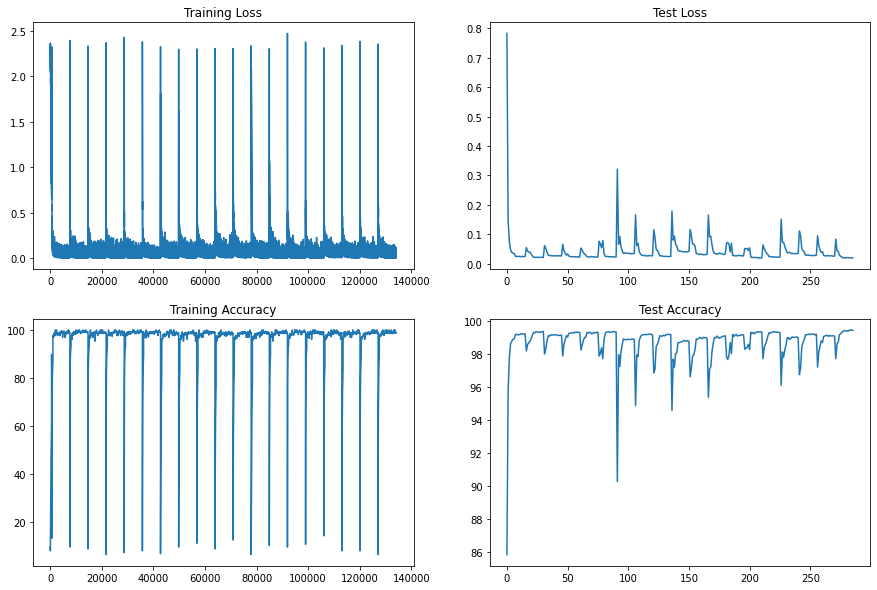

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")